# Capitales de México

Instalamos las dependencias para visualizar la ubicación de las ciudades de México.

In [0]:
!apt install proj-bin libproj-dev libgeos-dev
!pip install -U git+https://github.com/matplotlib/basemap.git

Definimos una clase para representar el mapa

In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 14 08:40:58 2019

@author: stan
"""
import geopy.distance as distance
import numpy as np
import pylab as pl
from IPython import display
from mpl_toolkits.basemap import Basemap

class MapaMexico:
    
    def __init__(self):
        pl.rcParams["figure.figsize"] = [12,8]
        m = Basemap(projection='lcc',
            lon_0=-121,lat_0=16,\
            llcrnrlat=16,urcrnrlat=30,\
            llcrnrlon=-121,urcrnrlon=-84,\
            rsphere=6371200.,\
            resolution='h')
        m.drawstates()
        m.drawcoastlines()
        m.drawcountries()
        m.fillcontinents(color='lightgray',zorder=0)
        self.m = m
        self.ciudades = {
        ('Aguascalientes Aguascalientes', 21.8475186, -102.305481910559),
        ('Mexicali Baja California', 32.6200699, -115.4440698),
        ('La Paz Baja California', 24.1017563, -110.4135535),
        ('Tuxtla Gutierrez Chiapas', 16.74521845,-93.1418086426027),
        ('Chihuahua Chihuahua',  28.938764, -106.384451167241),
        ('Campeche Campeche',  19.59188245, -90.25414928915),
        ('Saltillo Tamaulipas', 25.4466476, -100.9887188),
        ('Colima Colima',  19.0986013, -103.654240318428),
        ('Durango Durango', 23.9112721, -104.919810561772),
        ('Guanajuato Guanajuato', 21.02405745, -101.242782801753),
        ('Chilpancingo Guerrero', 17.5542149, -99.5048416),
        ('Pachuca Hidalgo', 20.1165413, -98.7413535),
        ('Guadalajara Jalisco', 20.676143, -103.3469982),
        ('Toluca Mexico', 19.2819217, -99.4890962),
        ('Morelia Michoacan', 19.7027116, -101.1923818),
        ('Cuernavaca Morelos', 18.9218274, -99.2342282),
        ('Tepic Nayarit', 21.7206915, -105.1423419),
        ('Monterrey Nuevo Leon', 25.63978365, -100.293101629066),
        ('Oaxaca Oaxaca', 17.0604663, -96.7253575),
        ('Puebla Puebla', 19.0437227, -98.1984744),
        ('Queretaro Queretaro', 20.5878372, -100.3879904),
        ('Chetumal Quintana Roo', 18.5132414, -88.3006444),
        ('San Luis Potosi San Luis Potosi', 22.3089625, -100.926198413959),
        ('Culiacan Sinaloa', 24.8015732, -107.3936301),
        ('Hermosillo Sonora', 29.0894152, -110.9612378),
        ('Villa Hermosa Tabasco', 17.992608, -92.9881407),
        ('Ciudad Victoria Tamaulipas', 23.7439573, -99.1419341),
        ('Tlaxcala Tlaxcala', 19.3173725, -98.2376413321235),
        ('Xalapa Veracruz', 19.5274085, -96.9238793),
        ('Merida Yucatan', 20.9670759, -89.6237402),
        ('Zacatecas Zacatecas', 22.7293312, -102.668598836424),
        ('Ciudad de México CDMX', 19.4326, -99.1332)}
        self.n = len(self.ciudades)
        self.coordinates = {c:(lat,long) for c,lat,long in self.ciudades}
        self.C, self.Y, self.X = zip(*self.ciudades)
        self.locs = np.matrix(list(zip(self.Y,self.X)))
        self.show_ciudades()
  
    def show_ciudades(self):
        X,Y = self.m(self.X,self.Y)
        self.m.scatter(X, Y,color='red',s=20,marker='o',zorder=1)
        
    def compute_distance(self,coords_1,coords_2):
        return distance.vincenty(coords_1, coords_2).km
      
    def compute_distance_by_name(self,a,b):
        return self.compute_distance(self.coordinates[a],self.coordinates[b])
      
    def print_ruta(self,ruta):
        print("\n".join([self.C[i] for i in ruta]))

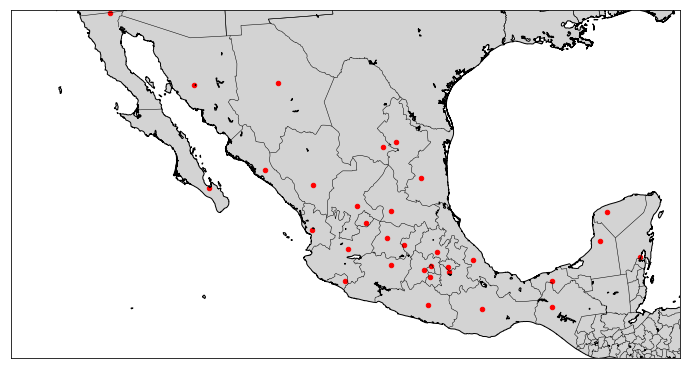

In [0]:
mexico = MapaMexico()

Probamos el cálculo de distancias en kms.

In [0]:
mexico.compute_distance_by_name('Ciudad de México CDMX','Toluca Mexico')

40.94376225571092

Traemos la definición de problema de búsqueda local.

In [0]:
from abc import ABCMeta, abstractmethod
class LocalSearchProblem:
    """
    Un problema de búsqueda local
    """
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def aleatoria(self):
        """
        Obtiene un estado aleatorio del problema
        :return: un estado aleatorio
        """
        pass
    
    @abstractmethod
    def energia(self,x):
        """
        Calcula la energía de un estado
        :param x: el estado al que se calculará la energía
        :return: la energía del estado
        """
        pass
    
    def move(self,x):
        """
        Una solución vecina a un estado dado
        :param x: la solución de referencia
        :return: una solución vecina a x
        """
        pass
    
    def show(self,x):
        """
        Muestra graficamente la solución x
        :param x: el estado a mostrar
        """
        pass

Y la definición del algoritmo de templado simulado.

In [0]:
import numpy as np
class SimulatedAnnealing:
    """
    Implementación del algoritmo de templado simulado
    """
    
    @staticmethod
    def search(problema,c_enfriamiento,Tinit,Tend,n,K=10):
        """
        Busqueda SA
        :param problema: el problema a resolver
        :param c_enfriamiento: constante de enfriamiento
        :param Tinit: temperatura inicial
        :param Tend: temperatura final
        :param n: número de iteraciones a cada temperatura
        (iteraciones para equilibrio térmico)
        :return: una tupla con el estado de menor energía 
        como primer elemento y su energía como segundo.
        """
        # Obtenemos del problema una solución aleatoria
        x = problema.aleatoria()
        # Calculamos su energía
        v = problema.energia(x)
        # Establecemos la temperatura del sistema igual a la
        # temperatura inicial
        T = Tinit
        # número de iteración
        it = 0
        # Mientras no se alcance la temperatura inicial
        while T > Tend:
            for i in range(0,n):
                # Obtenemos una nueva solución vecina a partir de la 
                # solución actual
                xp = problema.move(x)
                # Calculamos la energía de la nueva solución
                vp = problema.energia(xp)
                # Si la energía de la nueva solución es menor o igual
                # a la de la solución actual
                if (vp <= v):
                    #aceptamos la solución nueva
                    x,v = xp,vp
                # Si tenemos una solución de mayor energía
                else:
                    # calculamos la probabilidad de aceptarla
                    p_acept = np.exp(-(vp-v)/T)
                    # simulación estocástica
                    r = np.random.uniform()
                    if(r < p_acept):
                        # aceptamos la solución de mayor energía
                        x,v = xp,vp
            # Enfriamos el sistema tras equilibrio térmico
            T = c_enfriamiento*T 
            # Mostramos el estado de manera gráfica
            if it%K==0:
                problema.show(x)
            # incrementamos la iteracion
            it = it+1
        # regresamos la solución y su energía en una tupla
        return (x,v)

Generamos una clase que hereda de un problema de búsqueda local y del mapa de México.

In [0]:
import random
from random import randint
import pylab as pl
from IPython import display

class MapaMexicoLS(MapaMexico,LocalSearchProblem):
    
    def __init__(self):
        MapaMexico.__init__(self)
        self.lines = None
       
    def aleatoria(self):
        """
        Un estado aleatorio
        :return: el estado
        """
        conf = list(range(0,self.n))
        random.shuffle(conf)
        return conf
      
    def energia(self,permutacion):
        """
        La energía de un estado
        :param permutacion: la permutación de ciudades
        :return: el costo de la ruta
        """
        # x is a permutation
        M1 = self.locs[permutacion,:][[i%self.n for i in range(0,self.n+1)]]
        M2 = M1[[i%self.n for i in range(1,self.n+2)],:]
        return np.sum(
            np.apply_along_axis(
              lambda x:self.compute_distance((x[0,0],x[0,1]),(x[0,2],x[0,3])),
              1,
              np.hstack((M1,M2))))

    def move(self,x):
        """
        Una solución vecina aleatoria
        :param x: la permutación de referencia
        :
        """
        # creamos una copia para no alterar
        # la solución original
        xp = x.copy()
        i=randint(0,self.n-1)
        j=randint(0,self.n-1)
        
        xp[i],xp[j]=xp[j],xp[i]
        
        return xp
        
    def show(self,permutation):
        """
        Muestra graficamente la permutación x
        :param permutacion: la permutación a mostrar
        """
        ax = pl.gca()
        if self.lines:
            ax.lines.remove(self.lines)
            display.display(pl.gcf())
            display.clear_output(wait=True)
        if len(permutation)==0:
            permutation = list(range(self.n))
            show_lines = False
        else:
            show_lines = True
        
        M = self.locs[permutation,:]
        X = M[[i%self.n for i in range(0,self.n+1)],0]
        Y = M[[i%self.n for i in range(0,self.n+1)],1]
        X,Y = self.m(Y,X)

        if show_lines:
            self.lines,= pl.plot(X,Y,color="blue")
            print('Costo de la solución = '+\
            str(self.energia(permutation)))
            display.display(pl.gcf())
            display.clear_output(wait=True)
        else:
            display.display(pl.gcf())
            display.clear_output(wait=True)

Resolvemos la ruta con recocido simulado.

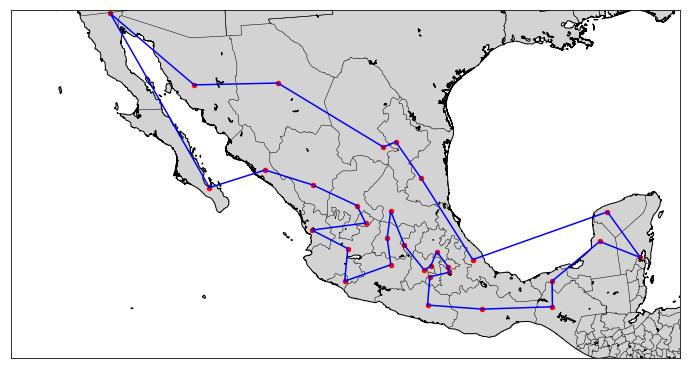

In [0]:
# Semilla de pseudoaleatorios
random.seed(201908)
# Una instancia del problema de las capitales
mexicols = MapaMexicoLS()
# El parámetro K es para mostrar como va la solución 
# tras K iteraciones de enfriamiento
solucion,costo = SimulatedAnnealing.search(
    problema=mexicols,c_enfriamiento=0.99,Tinit=5000,Tend=1,n=200,K=50)

In [0]:
print("ruta encontrada:")
mexicols.print_ruta(solucion)

ruta encontrada:
Aguascalientes Aguascalientes
Zacatecas Zacatecas
Durango Durango
Culiacan Sinaloa
La Paz Baja California
Mexicali Baja California
Hermosillo Sonora
Chihuahua Chihuahua
Saltillo Tamaulipas
Monterrey Nuevo Leon
Ciudad Victoria Tamaulipas
Xalapa Veracruz
Merida Yucatan
Chetumal Quintana Roo
Campeche Campeche
Villa Hermosa Tabasco
Tuxtla Gutierrez Chiapas
Oaxaca Oaxaca
Chilpancingo Guerrero
Cuernavaca Morelos
Puebla Puebla
Tlaxcala Tlaxcala
Pachuca Hidalgo
Ciudad de México CDMX
Toluca Mexico
Queretaro Queretaro
San Luis Potosi San Luis Potosi
Guanajuato Guanajuato
Morelia Michoacan
Colima Colima
Guadalajara Jalisco
Tepic Nayarit


# Ejercicio de clase

Encuentra la ruta, ahora utilizando el algoritmo genético.